In [1]:
from skimage import feature, color, transform, io
import numpy as np
import logging

In [2]:
def compute_edgelets(image, sigma=3):
    """Create edgelets."""
    gray_img = color.rgb2gray(image)
    edges = feature.canny(gray_img, sigma)
    lines = transform.probabilistic_hough_line(edges, line_length=3,
                                               line_gap=2)

    locations = []
    directions = []
    strengths = []

    for p0, p1 in lines:
        p0, p1 = np.array(p0), np.array(p1)
        locations.append((p0 + p1) / 2)
        directions.append(p1 - p0)
        strengths.append(np.linalg.norm(p1 - p0))

    # convert to numpy arrays and normalize
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)

    directions = np.array(directions) / \
        np.linalg.norm(directions, axis=1)[:, np.newaxis]

    return (locations, directions, strengths)

In [3]:
def edgelet_lines(edgelets):
    """Compute lines in homogenous system for edglets."""
    locations, directions, _ = edgelets
    normals = np.zeros_like(directions)
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1)
    return lines

def compute_votes(edgelets, model, threshold_inlier=5):
    """Compute votes for each of the edgelet against a given vanishing point."""
    vp = model[:2] / model[2]

    locations, directions, strengths = edgelets

    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * \
        np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5

    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))

    theta_thresh = threshold_inlier * np.pi / 180
    return (theta < theta_thresh) * strengths

In [4]:
def ransac_vanishing_point(edgelets, num_ransac_iter=2000, threshold_inlier=5):
    """Estimate vanishing point using Ransac."""
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 2]

    best_model = None
    best_votes = np.zeros(num_pts)

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]

        current_model = np.cross(l1, l2)

        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # reject degenerate candidates
            continue

        current_votes = compute_votes(
            edgelets, current_model, threshold_inlier)

        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            logging.info("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))

    return best_model


In [5]:
def ransac_3_line(edgelets, focal_length, num_ransac_iter=2000,
                  threshold_inlier=5):
    """Estimate orthogonal vanishing points using 3 line Ransac algorithm."""
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 5]
    third_index_space = arg_sort[:num_pts // 2]

    best_model = (None, None)
    best_votes = 0

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)
        ind3 = np.random.choice(third_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]
        l3 = lines[ind3]

        vp1 = np.cross(l1, l2)
        # The vanishing line polar to v1
        h = np.dot(vp1, [1 / focal_length**2, 1 / focal_length**2, 1])
        vp2 = np.cross(h, l3)

        if np.sum(vp1**2) < 1 or vp1[2] == 0:
            # reject degenerate candidates
            continue

        if np.sum(vp2**2) < 1 or vp2[2] == 0:
            # reject degenerate candidates
            continue

        vp1_votes = compute_votes(edgelets, vp1, threshold_inlier)
        vp2_votes = compute_votes(edgelets, vp2, threshold_inlier)
        current_votes = (vp1_votes > 0).sum() + (vp2_votes > 0).sum()

        if current_votes > best_votes:
            best_model = (vp1, vp2)
            best_votes = current_votes
            logging.info("Current best model has {} votes at iteration {}".format(
                current_votes, ransac_iter))

    return best_model


In [6]:
def reestimate_model(model, edgelets, threshold_reestimate=5):
    """Reestimate vanishing point using inliers and least squares."""
    locations, directions, strengths = edgelets

    inliers = compute_votes(edgelets, model, threshold_reestimate) > 0
    locations = locations[inliers]
    directions = directions[inliers]
    strengths = strengths[inliers]

    lines = edgelet_lines((locations, directions, strengths))

    a = lines[:, :2]
    b = -lines[:, 2]
    est_model = np.linalg.lstsq(a, b)[0]
    return np.concatenate((est_model, [1.]))

def remove_inliers(model, edgelets, threshold_inlier=10):
    """Remove all inlier edglets of a given model."""
    inliers = compute_votes(edgelets, model, 10) > 0
    locations, directions, strengths = edgelets
    locations = locations[~inliers]
    directions = directions[~inliers]
    strengths = strengths[~inliers]
    edgelets = (locations, directions, strengths)
    return edgelets


In [7]:
def compute_homography_and_warp(image, vp1, vp2, clip=True, clip_factor=3):
    """Compute homography from vanishing points and warp the image."""
    # Find Projective Transform
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # Translate so that whole of the image is covered
    inter_matrix = np.dot(A, H)

    cords = np.dot(inter_matrix, [[0, 0, image.shape[1], image.shape[1]],
                                  [0, image.shape[0], 0, image.shape[0]],
                                  [1, 1, 1, 1]])
    cords = cords[:2] / cords[2]

    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    final_homography = np.dot(T, inter_matrix)

    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img


In [11]:
def vis_edgelets(image, edgelets, show=True):
    """Helper function to visualize edgelets."""
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    locations, directions, strengths = edgelets
    for i in range(locations.shape[0]):
        xax = [locations[i, 0] - directions[i, 0] * strengths[i] / 2,
               locations[i, 0] + directions[i, 0] * strengths[i] / 2]
        yax = [locations[i, 1] - directions[i, 1] * strengths[i] / 2,
               locations[i, 1] + directions[i, 1] * strengths[i] / 2]

        plt.plot(xax, yax, 'r-')

    if show:
        plt.show()

def vis_model(image, model_1,model_2, show=True):
    """Helper function to visualize computed model."""
    import matplotlib.pyplot as plt
    edgelets = compute_edgelets(image)
    locations, directions, strengths = edgelets
    inliers1 = compute_votes(edgelets, model_1, 10) > 0
    inliers2 = compute_votes(edgelets, model_2, 10) > 0

    edgelets1 = (locations[inliers1], directions[inliers1], strengths[inliers1])
    edgelets2 = (locations[inliers2], directions[inliers2], strengths[inliers2])
    locations1, directions1, strengths1 = edgelets1
    locations2, directions2, strengths2 = edgelets2
    vis_edgelets(image, edgelets1, False)
    vis_edgelets(image, edgelets2, False)
    vp1 = model_1 / model_1[2]
    vp2 = model_2 / model_2[2]
    plt.plot(vp1[0], vp1[1], 'bo')
    plt.plot(vp2[0], vp2[1], 'bo')
    plt.plot([vp1[0],vp2[0]],[vp1[1],vp2[1]],'c-')
    for i in range(locations1.shape[0]):
        xax = [locations1[i, 0], vp1[0]]
        yax = [locations1[i, 1], vp1[1]]
        plt.plot(xax, yax, 'b-.')
    for j in range(locations2.shape[0]):
        xax = [locations2[j, 0], vp2[0]]
        yax = [locations2[j, 1], vp2[1]]
        plt.plot(xax, yax, 'r-.')

    if show:
        plt.show()

def rectify_image(image, clip_factor=6, algorithm='independent', 
                  reestimate=False):
    """Rectified image with vanishing point computed using ransac."""
    if type(image) is not np.ndarray:
        image = io.imread(image)

    # Compute all edgelets.
    edgelets1 = compute_edgelets(image)

    if algorithm == 'independent':
        # Find first vanishing point
        vp1 = ransac_vanishing_point(edgelets1, 2000, threshold_inlier=5)
        if reestimate:
            vp1 = reestimate_model(vp1, edgelets1, 5)

        # Remove inlier to remove dominating direction.
        edgelets2 = remove_inliers(vp1, edgelets1, 10)

        # Find second vanishing point
        vp2 = ransac_vanishing_point(edgelets2, 2000, threshold_inlier=5)
        if reestimate:
            vp2 = reestimate_model(vp2, edgelets2, 5)
    elif algorithm == '3-line':
        focal_length = None
        vp1, vp2 = ransac_3_line(edgelets1, focal_length,
                                 num_ransac_iter=3000, threshold_inlier=5)
    else:
        raise KeyError(
            "Parameter 'algorithm' has to be one of {'3-line', 'independent'}")

    # Compute the homography and warp
    warped_img = compute_homography_and_warp(image, vp1, vp2,
                                             clip_factor=clip_factor)

    return warped_img


Rectifying C:\Users\jitbh\OneDrive\Desktop\DSC_0714.jpg


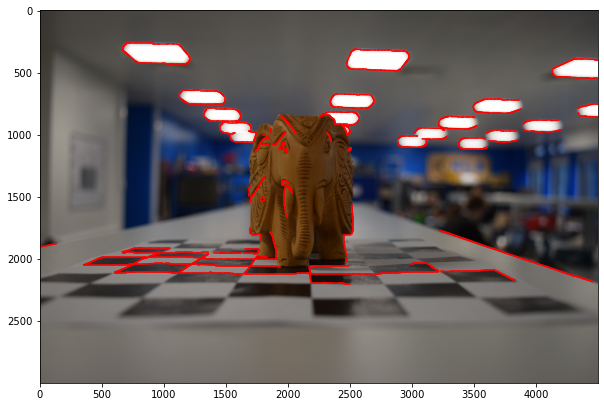

<ipython-input-3-78193c1fe75e>:24: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.abs(cosine_theta))
<ipython-input-6-9bc2fed4bb8c>:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  est_model = np.linalg.lstsq(a, b)[0]


[array([8.89151231e+03, 1.39762362e+03, 1.00000000e+00])] [array([2.15309185e+03, 1.42008822e+03, 1.00000000e+00])]


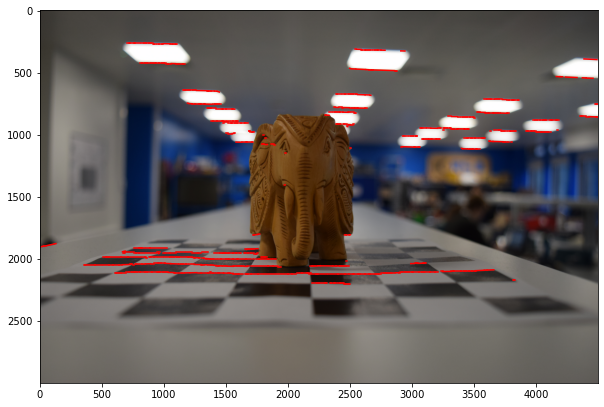

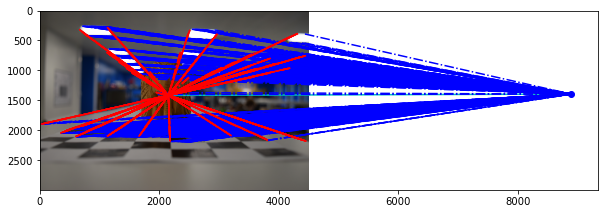

In [13]:
if __name__ == '__main__':

    image_name =r'C:\Users\jitbh\OneDrive\Desktop\DSC_0714.jpg'

    image = io.imread(image_name)
    print("Rectifying {}".format(image_name))

    edgelets1 = compute_edgelets(image)
    vis_edgelets(image, edgelets1)  # Visualize the edgelets
    vp1 = ransac_vanishing_point(edgelets1, num_ransac_iter=2000,threshold_inlier=5)
    vp1 = reestimate_model(vp1, edgelets1, threshold_reestimate=5)

    edgelets2 = remove_inliers(vp1, edgelets1, 10)
    vp2 = ransac_vanishing_point(edgelets2, num_ransac_iter=2000,threshold_inlier=5)
    vp2 = reestimate_model(vp2, edgelets2, threshold_reestimate=5)
    print([vp1], [vp2])
    vis_model(image, vp1,vp2)  # Visualize the vanishing point model